# Training - Human Face Detection Task

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import time
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder

In [2]:
import sys
AI_MODEL_ROOT = os.path.join(
    os.path.dirname(os.path.realpath(os.curdir)),
)
sys.path.append(AI_MODEL_ROOT)

In [3]:
import constants
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from image_preprocessing import decode_labels

## Load the Processed Data

In [4]:
# Define Paths
TRAIN_PATHS = [
    # aliasgartaksali
    os.path.join(
        os.path.dirname(os.path.realpath(os.curdir)),
        'dataset',
        'aliasgartaksali',
        'human-and-non-human'
    ),
    # ashwingupta3012
    os.path.join(
        os.path.dirname(os.path.realpath(os.curdir)),
        'dataset',
        'ashwingupta3012',
        'human-faces'
    )
]
VAL_PATH = [
    # olivetti_faces
    os.path.join(
        os.path.dirname(os.path.realpath(os.curdir)),
        'dataset',
        'olivetti_faces'
    )
]

In [5]:
X_TRAIN = np.array([])
Y_TRAIN = np.array([])
X_TEST = np.array([])
Y_TEST = np.array([])

for path in TRAIN_PATHS:
    print("Extracting Data from", path)
    if 'features' in os.listdir(path):
        X_train_new = np.load(os.path.join(path, 'features', 'X_train.npy'))
        X_test_new = np.load(os.path.join(path, 'features', 'X_test.npy'))

        if X_TRAIN.size == 0:
            X_TRAIN = X_train_new
        else:
            X_TRAIN = np.concatenate((X_TRAIN, X_train_new), axis=0)
            
        if X_TEST.size == 0:
            X_TEST = X_test_new
        else:
            X_TEST = np.concatenate((X_TEST, X_test_new), axis=0)
        print(f"Data Extracted Successfully from {path}")
    if 'labels' in os.listdir(path):
        y_train_new = np.load(os.path.join(path, 'labels', 'y_train.npy'))
        y_test_new = np.load(os.path.join(path, 'labels', 'y_test.npy'))

        if Y_TRAIN.size == 0:
            Y_TRAIN = y_train_new
        else:
            Y_TRAIN = np.concatenate((Y_TRAIN, y_train_new), axis=0)
        
        if Y_TEST.size == 0:
            Y_TEST = y_test_new
        else:
            Y_TEST = np.concatenate((Y_TEST, y_test_new), axis=0)
        print(f"Data Extracted Successfully from {path}")


Extracting Data from C:\projects\GenAI\AI_Model\dataset\aliasgartaksali\human-and-non-human
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\aliasgartaksali\human-and-non-human
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\aliasgartaksali\human-and-non-human
Extracting Data from C:\projects\GenAI\AI_Model\dataset\ashwingupta3012\human-faces
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\ashwingupta3012\human-faces
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\ashwingupta3012\human-faces


In [6]:
print(f"Shape of X_TRAIN: {X_TRAIN.shape}")
print(f"Shape of Y_TRAIN: {Y_TRAIN.shape}")
print(f"Shape of X_TEST: {X_TEST.shape}")
print(f"Shape of Y_TEST: {Y_TEST.shape}")

Shape of X_TRAIN: (8417, 64, 64)
Shape of Y_TRAIN: (8417,)
Shape of X_TEST: (2823, 64, 64)
Shape of Y_TEST: (2823,)


In [7]:
X_VAL = np.array([])
Y_VAL = np.array([])

for path in VAL_PATH:
    print("Extracting Data from", path)
    if 'features' in os.listdir(path):
        X_val_new = np.load(open(os.path.join(path, 'features', 'olivetti_faces_preprocessed.npy'), 'rb'))
        if X_VAL.size == 0:
            X_VAL = X_val_new
        else:
            X_VAL = np.concatenate((X_VAL, X_val_new), axis=0)
    if 'label' in os.listdir(path):
        y_val_new = np.load(open(os.path.join(path, 'label', 'is_human_label.npy'), 'rb'))
        if Y_VAL.size == 0:
            Y_VAL = y_val_new
        else:
            Y_VAL = np.concatenate((Y_VAL, y_val_new), axis=0)
    print(f"Data Extracted Successfully from {path}")
assert X_VAL.shape[0] == Y_VAL.shape[0]

Extracting Data from C:\projects\GenAI\AI_Model\dataset\olivetti_faces
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\olivetti_faces


In [8]:
X_VAL.shape, Y_VAL.shape

((400, 64, 64), (400,))

## Construct a Network

Guide: https://medium.com/@raguwing/face-recognition-using-cnn-architecture-in-python-f3c302c2164f

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [10]:
Model = Sequential()
Model

<Sequential name=sequential, built=False>

In [11]:
''' STEP--1 Convolution
# Adding the first layer of CNN
# we are using the format (64,64) because we are using TensorFlow backend
# It means 3 matrix of size (64x64)) pixels representing Red, Green and Blue components of pixels
'''

# Add a channel dimension to the input shape
input_shape = (constants.img_height, constants.img_width, 1)  # Assuming grayscale images

Model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), input_shape=input_shape, activation='relu'))
Model

c:\projects\GenAI\genai-venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [12]:
'''# Maxplooing layer'''

Model.add(MaxPool2D(pool_size=(2,2)))
Model

<Sequential name=sequential, built=True>

In [13]:
'''Adding additional layers  of convolution and 
        maxpooling for better model accuracy and performance'''

Model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model

<Sequential name=sequential, built=True>

In [14]:
'''# Add a flatten layer to convert the vector to one dimensional'''
Model.add(Flatten())
Model

<Sequential name=sequential, built=True>

In [15]:
'''Add dense layers and Initialize weights using 
                kernal initializer for better learing of image features and classification'''

Model.add(Dense(64,activation='relu'))
Model.add(Dense(64,activation='relu'))
Model.add(Dense(2, activation='softmax'))
Model

<Sequential name=sequential, built=True>

In [16]:
'''Perform Model Compilation'''

Model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics = ['Accuracy'])
Model

<Sequential name=sequential, built=True>

In [17]:
from keras.utils import to_categorical

# One-hot encode the labels
num_classes = 2
Y_TRAIN = to_categorical(Y_TRAIN, num_classes=num_classes)
Y_VAL = to_categorical(Y_VAL, num_classes=num_classes)

In [18]:
Y_TRAIN.shape, Y_VAL.shape

((8417, 2), (400, 2))

In [19]:
'''# Using Early stopping to reduce the training time'''

call = EarlyStopping(
    min_delta=0.005,
    patience=5,
    verbose=1
)

# Measuring the time taken by the model to train
StartTime=time.time()

'''# Model Training'''
history = Model.fit(
    X_TRAIN, Y_TRAIN,
    epochs=30,
    validation_data=(X_VAL, Y_VAL),
    callbacks=[call]
)

Endtime = time.time()
print('Total Training Time taken: ',round((Endtime-StartTime)/60),'Minutes')

Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - Accuracy: 0.8255 - loss: 0.3633 - val_Accuracy: 0.0200 - val_loss: 3.7634
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9716 - loss: 0.0845 - val_Accuracy: 0.0025 - val_loss: 3.7698
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9786 - loss: 0.0583 - val_Accuracy: 0.0125 - val_loss: 3.7520
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9847 - loss: 0.0496 - val_Accuracy: 0.0125 - val_loss: 3.5687
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9860 - loss: 0.0339 - val_Accuracy: 0.0025 - val_loss: 5.8333
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9943 - loss: 0.0190 - val_Accuracy: 0.0150 - val_loss: 5.5190
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9951 - loss: 0.0161 - val_Accuracy: 0.1000 - val_loss: 4.3392
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.9974 - loss: 0.0091 - val_Accu

In [20]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,232,456 (4.70 MB)

 Trainable params: 410,818 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 821,638 (3.13 MB)

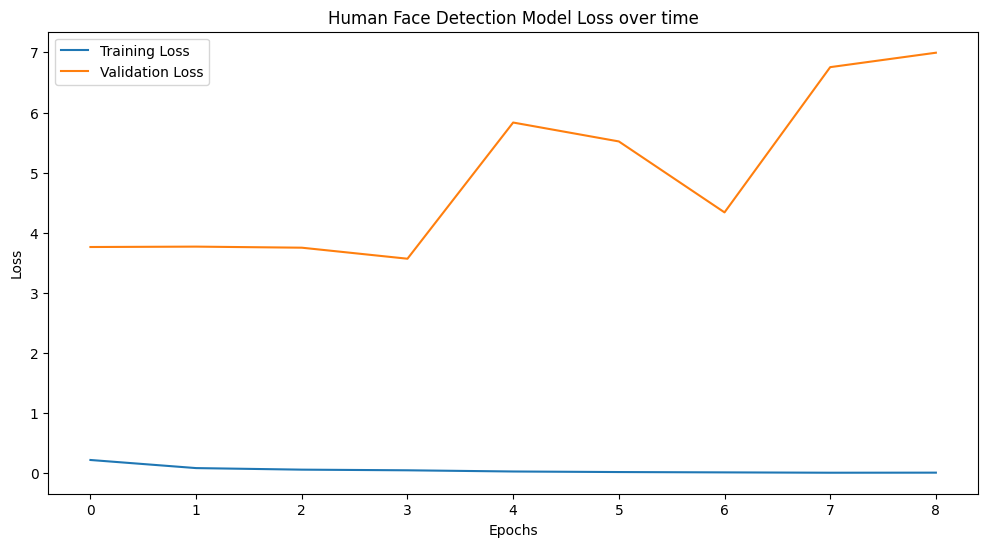

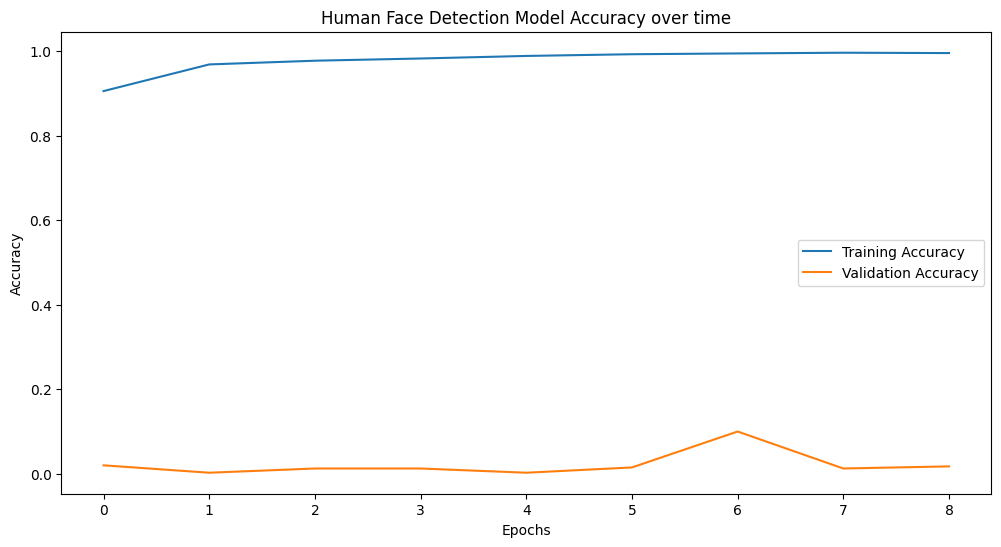

In [21]:
# Plotting Loss over time
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Human Face Detection Model Loss over time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy over time
plt.figure(figsize=(12, 6))
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.title('Human Face Detection Model Accuracy over time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Save the Model
Model.save(os.path.join(AI_MODEL_ROOT, 'human_face_detection_model.h5'))
print("Model Saved Successfully!")

Model Saved Successfully!


## Evaluating the Model

In [23]:
# Make Predictions
pred = Model.predict(X_TEST)
pred

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[5.5517745e-07, 9.9999940e-01],
       [2.5186768e-05, 9.9997485e-01],
       [3.2143428e-06, 9.9999678e-01],
       ...,
       [9.9999952e-01, 4.4655783e-07],
       [9.9999940e-01, 5.4309464e-07],
       [9.9972934e-01, 2.7061458e-04]], shape=(2823, 2), dtype=float32)

In [24]:
# One-Hot Decode the Predictions
pred = np.argmax(pred, axis=1)
pred

array([1, 1, 1, ..., 0, 0, 0], shape=(2823,))

Accuracy: 0.9613885936946511
Precision: 0.986223662884927
Recall: 0.9297173414820473
Macro F1 Score: 0.9610049716579632
Micro F1 Score: 0.9613885936946511
AUC: 0.9592444038982231


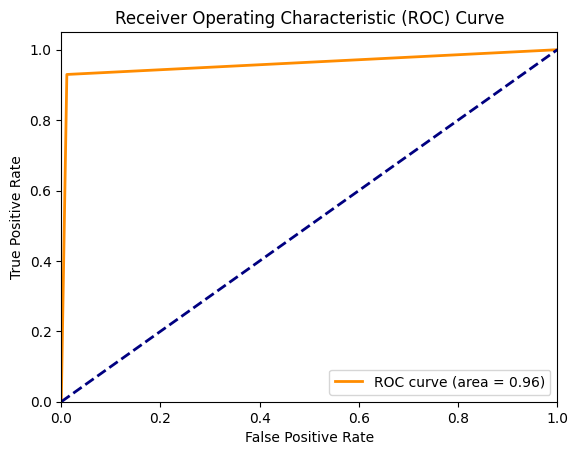

In [25]:
# Decode the Labels with Label Encoder
encoderTest_ali = pickle.load(open(os.path.join(
    AI_MODEL_ROOT, 
    'dataset',
    'aliasgartaksali',
    'human-and-non-human',
    'encoderTest.pkl'
), 'rb'))
encoderTest_ashwing = np.load(open(os.path.join(
    AI_MODEL_ROOT, 
    'dataset',
    'ashwingupta3012',
    'human-faces',
    'encoders',
    'encoder_test.npy'
), 'rb'), allow_pickle=True).item()

# Extract labels from both encoders
labels_apollo = encoderTest_ali.classes_
labels_tapakah = encoderTest_ashwing.classes_

# Combine the labels into a single set
combined_labels = np.unique(np.concatenate((labels_apollo, labels_tapakah)))

# Fit a new label encoder on the combined set of labels
unified_encoder = LabelEncoder()
unified_encoder.fit(combined_labels)

# X_TEST is a combination of both the datasets
# Y_TEST is the ground truth
# Goal: compare the predictions with the ground truth
# Evaluate accuracy
accuracy = accuracy_score(Y_TEST, pred)
print(f"Accuracy: {accuracy}")

# Evaluate precision
precision = precision_score(Y_TEST, pred)
print(f"Precision: {precision}")

# Evaluate recall
recall = recall_score(Y_TEST, pred)
print(f"Recall: {recall}")

# Evaluate macro and micro F1 scores
macro_f1 = f1_score(Y_TEST, pred, average='macro')
micro_f1 = f1_score(Y_TEST, pred, average='micro')
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

# Evaluate AUC
auc_score = roc_auc_score(Y_TEST, pred)
print(f"AUC: {auc_score}")

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(Y_TEST, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Predicting the 2006 image from test set: 


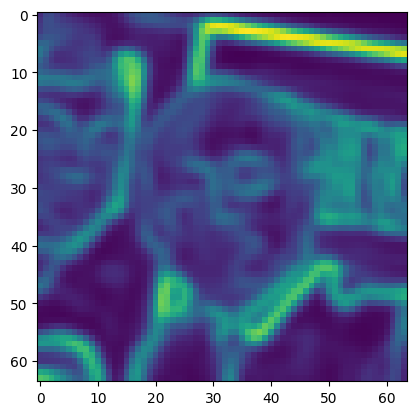

The above image is predicted as: humans
The actual label of the image is: humans


In [26]:
# Show a random prediction in human readable format
index = random.randint(0, len(pred))
image = X_TEST[index]
pred_item = pred[index]
actual_item = Y_TEST[index]
print(f"Predicting the {index} image from test set: ")
plt.imshow(image)
plt.show()

encoder = pickle.load(open(os.path.join(
    AI_MODEL_ROOT,
    'dataset',
    'aliasgartaksali',
    'human-and-non-human',
    'encoderTest.pkl'
), 'rb'))
pred_item_text = decode_labels(
    encoded_labels=[pred_item],
    encoder=encoder
)[0]
actual_item_text = decode_labels(
    encoded_labels=[actual_item],
    encoder=encoder
)[0]
print(f"The above image is predicted as: {pred_item_text}")
print(f"The actual label of the image is: {actual_item_text}")